
Training Transformer (baseline)
Training Transformer (baseline) on device: cuda
Epoch 1/40 | Loss 0.4103 | Val F1 0.554 | Acc 0.783
Epoch 2/40 | Loss 0.3555 | Val F1 0.549 | Acc 0.785
Epoch 3/40 | Loss 0.3525 | Val F1 0.546 | Acc 0.786
Epoch 4/40 | Loss 0.3512 | Val F1 0.592 | Acc 0.780
Epoch 5/40 | Loss 0.3494 | Val F1 0.483 | Acc 0.790
Epoch 6/40 | Loss 0.3484 | Val F1 0.515 | Acc 0.791
Epoch 7/40 | Loss 0.3471 | Val F1 0.528 | Acc 0.792
Epoch 8/40 | Loss 0.3469 | Val F1 0.499 | Acc 0.793
Epoch 9/40 | Loss 0.3450 | Val F1 0.564 | Acc 0.791
Epoch 10/40 | Loss 0.3435 | Val F1 0.558 | Acc 0.790
Epoch 11/40 | Loss 0.3430 | Val F1 0.532 | Acc 0.794
Epoch 12/40 | Loss 0.3420 | Val F1 0.480 | Acc 0.798
Epoch 13/40 | Loss 0.3408 | Val F1 0.476 | Acc 0.796
Epoch 14/40 | Loss 0.3394 | Val F1 0.436 | Acc 0.801
Epoch 15/40 | Loss 0.3384 | Val F1 0.557 | Acc 0.801
Epoch 16/40 | Loss 0.3376 | Val F1 0.521 | Acc 0.804
Epoch 17/40 | Loss 0.3341 | Val F1 0.543 | Acc 0.806
Epoch 18/40 | Loss 0.3316 |

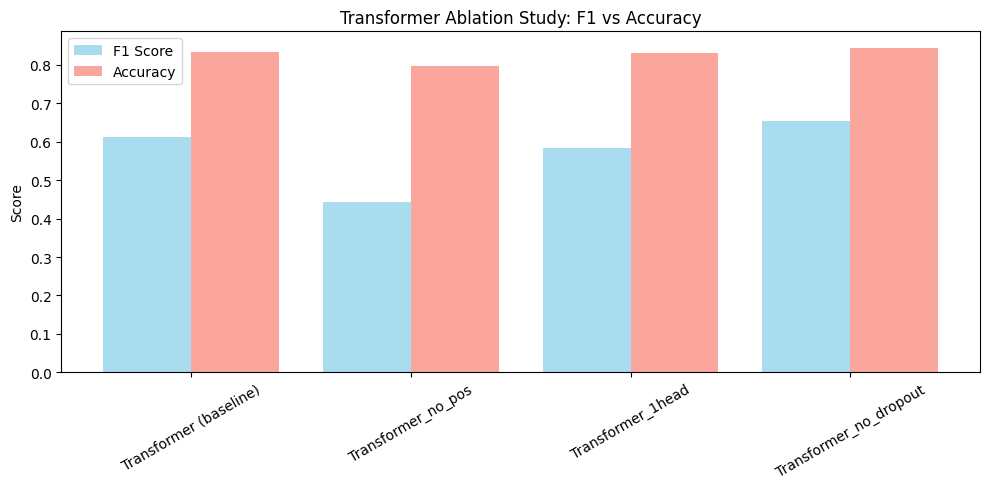

In [2]:
# -----------------------------
# TRANSFORMER ABLATION STUDY
# -----------------------------
import torch.nn as nn
import matplotlib.pyplot as plt

# Base Transformer (already defined in your code)
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, num_heads=4, num_layers=3, use_pos=True, dropout_rate=0.2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.use_pos = use_pos
        self.pos_embed = nn.Parameter(torch.randn(1, 200, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True,
            dropout=dropout_rate
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        self.fc = nn.Linear(embed_dim, 2)

    def forward(self, x):
        seq_len = x.size(1)
        x = self.embed(x)
        if self.use_pos:
            x = x + self.pos_embed[:, :seq_len, :]
        x = self.transformer(x)
        x = self.dropout(x)
        return self.fc(x)

# Ablation Variants
class Transformer_no_pos(TransformerModel):
    def __init__(self, vocab_size, embed_dim=64, num_heads=4, num_layers=3, dropout_rate=0.2):
        super().__init__(vocab_size, embed_dim, num_heads, num_layers, use_pos=False, dropout_rate=dropout_rate)

class Transformer_1head(TransformerModel):
    def __init__(self, vocab_size, embed_dim=64, num_layers=3, dropout_rate=0.2):
        super().__init__(vocab_size, embed_dim, num_heads=1, num_layers=num_layers, use_pos=True, dropout_rate=dropout_rate)

class Transformer_no_dropout(TransformerModel):
    def __init__(self, vocab_size, embed_dim=64, num_heads=4, num_layers=3):
        super().__init__(vocab_size, embed_dim, num_heads, num_layers, use_pos=True, dropout_rate=0.0)

# Dictionary of ablation models
ablation_models = {
    "Transformer (baseline)": TransformerModel,
    "Transformer_no_pos": Transformer_no_pos,
    "Transformer_1head": Transformer_1head,
    "Transformer_no_dropout": Transformer_no_dropout
}

# Train and evaluate each variant
ablation_results = {}
ablation_histories = {}

for name, cls in ablation_models.items():
    print(f"\nTraining {name}")
    model = cls(vocab_size=VOCAB_SIZE)
    trained_model, train_losses, val_f1s = train_model(model, train_loader, val_loader, epochs=40, lr=1e-3, model_name=name)
    p, r, f, acc = evaluate(trained_model, test_loader)
    
    ablation_results[name] = {'precision': p, 'recall': r, 'f1': f, 'accuracy': acc}
    ablation_histories[name] = {'train_loss': train_losses, 'val_f1': val_f1s}

# -----------------------------
# Display Results Table
# -----------------------------
print("\nABALATION STUDY RESULTS")
print(f"{'Model Variant':<25} {'F1 Score':<10} {'Accuracy':<10}")
print("-"*50)
for name, metrics in ablation_results.items():
    print(f"{name:<25} {metrics['f1']:<10.3f} {metrics['accuracy']:<10.3f}")

# -----------------------------
# Bar Plot Visualization
# -----------------------------
models = list(ablation_results.keys())
f1_scores = [ablation_results[m]['f1'] for m in models]
accuracies = [ablation_results[m]['accuracy'] for m in models]

plt.figure(figsize=(10,5))
x = range(len(models))
plt.bar(x, f1_scores, width=0.4, label='F1 Score', alpha=0.7, color='skyblue')
plt.bar([i + 0.4 for i in x], accuracies, width=0.4, label='Accuracy', alpha=0.7, color='salmon')
plt.xticks([i + 0.2 for i in x], models, rotation=30)
plt.ylabel("Score")
plt.title("Transformer Ablation Study: F1 vs Accuracy")
plt.legend()
plt.tight_layout()
plt.show()
